In [1]:
# Simulate the cell growth

import numpy
import random
import matplotlib.pyplot
import pathlib

In [2]:
# Create an area for the dish:


def create_dish(dish_radius):
    dish_x, dish_y = numpy.meshgrid(range(-dish_radius, dish_radius), range(-dish_radius, dish_radius))
    valid_area = numpy.zeros(dish_x.shape, bool)
    valid_area[numpy.sqrt(dish_x**2 + dish_y**2) < dish_radius] = 1

    # Create the dish
    dish = numpy.zeros(dish_x.shape, numpy.uint16)
    dish[valid_area] = 1
    return dish

Valid area (64, 64):


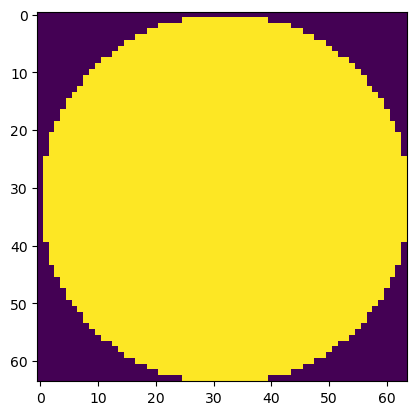

In [3]:
dish_radius = 32

dish = create_dish(dish_radius)
# Check if the valid area forms a dish
print(f"Valid area {dish.shape}:")
matplotlib.pyplot.imshow(dish)
matplotlib.pyplot.show()

In [4]:
# Set random seed
seed = 4135942
version = 2
random.seed(seed, 2)

nucleus_area = 3
cell_area = int(nucleus_area * 10)
cell_max_radius = int(numpy.sqrt(cell_area) / numpy.pi * 1.2)
injection_radius_center = min(int(dish_radius / 10) , 0)

In [5]:
def seed_dish(dish):
    center_x = random.randint(- injection_radius_center, injection_radius_center) + dish_radius
    center_y = random.randint(- injection_radius_center, injection_radius_center) + dish_radius + 2
    dish[center_x, center_y] = 2

Cell injected


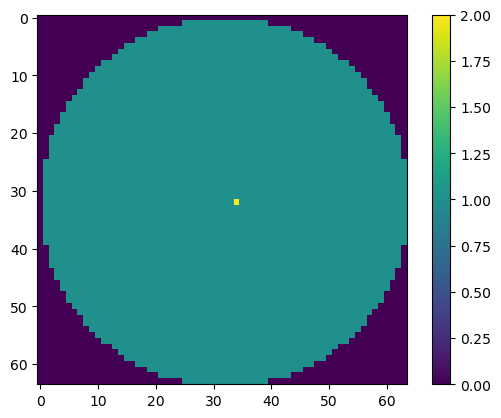

In [6]:
# Inject a cell around the middle
# The center is the even number and the body the uneven number
# 0 is invalid 1 is nutriet
seed_dish(dish)
print(f"Cell injected")
matplotlib.pyplot.imshow(dish)
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [7]:
def grow_cell(cell_index, dish):
    cell_nucleus_number = (cell_index + 1) * 2
    cell_body_number = cell_nucleus_number + 1
    nucleus_inidices = numpy.where(dish == cell_nucleus_number)
    window_left = max(numpy.min(nucleus_inidices[1]) - (cell_max_radius+2), 0)
    window_right = min(numpy.max(nucleus_inidices[1]) + (cell_max_radius+2), dish.shape[0])
    window_bottom = max(numpy.min(nucleus_inidices[0]) - (cell_max_radius+2), 0) 
    window_top = min(numpy.max(nucleus_inidices[0]) + (cell_max_radius+2), dish.shape[1])
    cell_grow_window = numpy.zeros((window_right - window_left, window_top - window_bottom), numpy.uint16)
    cell_grow_window = dish[window_bottom:window_top, window_left:window_right]
    # Grow / move the nucleus
    growth_cycles = 5
    for cycle in range(0, growth_cycles, 1):
        nucleus_neighbors = numpy.zeros(cell_grow_window.shape, bool)
        local_nucleus_inidices = numpy.where(cell_grow_window == cell_nucleus_number)
        
        local_cell_center_y = numpy.mean(local_nucleus_inidices[0])
        local_cell_center_x = numpy.mean(local_nucleus_inidices[1])
        for pixel_index in range(0, len(local_nucleus_inidices[0])):
            y = local_nucleus_inidices[0][pixel_index]
            x = local_nucleus_inidices[1][pixel_index]
            potential_neighbors = [(y + 1, x) , (y - 1, x), (y, x + 1), (y, x - 1)]
            for potential_neighbor in potential_neighbors:
                y, x = potential_neighbor
                if x >= 0 and x < window_right - window_left and y >= 0 and y < window_top - window_bottom:
                    if cell_grow_window[y, x] % 2 == 1:
                        nucleus_neighbors[y, x] = True
        # Grow core
        nucleus_size = len(local_nucleus_inidices[0])
        neighbor_points = numpy.where(nucleus_neighbors)
        for neighbor_index in range(0, len(neighbor_points[0]), 1):
            y = neighbor_points[0][neighbor_index]
            x = neighbor_points[1][neighbor_index]
            chance_to_grow = random.uniform(0, 1.0)
            maximal_nucelus_size = nucleus_area * 2
            nucleus_permitted_growth = maximal_nucelus_size - nucleus_size
            acceptance_growth = max((nucleus_permitted_growth), 0)  / 10
            if chance_to_grow < acceptance_growth:
                nucleus_size += 1
                nucleus_neighbors[y, x] = False 
                cell_grow_window[y, x] = cell_nucleus_number
        # Kill core
        core_points = numpy.where(cell_grow_window == cell_nucleus_number)
        for pixel_index in range(0, len(core_points[0]), 1):
            y = core_points[0][pixel_index]
            x = core_points[1][pixel_index]
            chance_to_die = random.uniform(0, 1.0)
            minimal_nucleus_area = max(int(nucleus_area / 2), 1)
            accept_death = max((nucleus_size - minimal_nucleus_area), 0) / 10
            if chance_to_die < accept_death:
                nucleus_size -= 1
                cell_grow_window[y, x] = cell_body_number
        # Grow cell area
        cell_neighbors = numpy.zeros(cell_grow_window.shape, bool)
        local_cell_indices = numpy.where(numpy.logical_or(cell_grow_window == cell_nucleus_number,cell_grow_window == cell_body_number))
        for pixel_index in range(0, len(local_cell_indices[0])):
            y = local_cell_indices[0][pixel_index]
            x = local_cell_indices[1][pixel_index]
            potential_neighbors = [(y + 1, x) , (y - 1, x), (y, x + 1), (y, x - 1)]
            for potential_neighbor in potential_neighbors:
                y, x = potential_neighbor
                if x >= 0 and x < window_right - window_left and y >= 0 and y < window_top - window_bottom:
                    if cell_grow_window[y, x] % 2 == 1:
                        cell_neighbors[y, x] = True
        # Grow cell
        cell_size = len(local_cell_indices[0])
        neighbor_points = numpy.where(cell_neighbors)
        for neighbor_index in range(0, len(neighbor_points[0]), 1):
            y = neighbor_points[0][neighbor_index]
            x = neighbor_points[1][neighbor_index]
            chance_to_grow = random.uniform(0, 1.0)
            maximal_cell_size = cell_area * 2
            cell_permitted_growth = maximal_cell_size - cell_size
            distance_to_center = numpy.sqrt((local_cell_center_y - y)**2 + (local_cell_center_x - x)**2)
            acceptance_growth = max((cell_permitted_growth), 0)  / 10
            acceptance_distance = (cell_max_radius - distance_to_center) / cell_max_radius
            if chance_to_grow < acceptance_growth and chance_to_grow < acceptance_distance:
                cell_size += 1
                cell_neighbors[y, x] = False 
                cell_grow_window[y, x] = cell_body_number
        # Kill cell
        cell_points = numpy.where(cell_grow_window == cell_body_number)
        for pixel_index in range(0, len(cell_points[0]), 1):
            y = cell_points[0][pixel_index]
            x = cell_points[1][pixel_index]
            chance_to_die = random.uniform(0, 1.0)
            minimal_cell_area = max(int(cell_area / 2), 1)
            distance_to_center = numpy.sqrt((local_cell_center_y - y)**2 + (local_cell_center_x - x)**2)
            accept_death = max((cell_size - minimal_cell_area), 0) / 10
            acceptance_distance = 1-0 - (cell_max_radius - distance_to_center) / cell_max_radius
            if chance_to_die < accept_death + acceptance_distance:
                cell_size -= 1
                cell_grow_window[y, x] = cell_body_number

In [8]:
def get_cell_cores(cell_index, dish):
    core_pixel = (dish == (cell_index + 1) * 2)
    core_pixel_indices = numpy.where(core_pixel)
    marking_area = numpy.zeros(dish.shape, numpy.uint16)
    for index in range(0, len(core_pixel_indices[0])):
        y = core_pixel_indices[0][index]
        x = core_pixel_indices[1][index]
        marking_area[y, x] = index + 1
    change_occured = True
    while change_occured:
        change_occured = False
        for index in range(0, len(core_pixel_indices[0])):
            y = core_pixel_indices[0][index]
            x = core_pixel_indices[1][index]
            current_index = marking_area[y, x]
            # Search neighbors
            bottom = max(y - 1, 0)
            top = min(y + 2, dish.shape[0])
            left = max(x - 1, 0)
            right = min(x + 2, dish.shape[1])
            neighbor_pixels = marking_area[bottom:top, left:right]
            neighbor_indices = set(numpy.unique(neighbor_pixels)) - {0}
            lowest_index = sorted(neighbor_indices)[0]
            if lowest_index < current_index:
                # Use the closest possible index
                marking_area[y, x] = lowest_index        
                change_occured = True
    cell_centre_indices = sorted(set(numpy.unique(marking_area)) - {0})
    cell_centres = [numpy.where(marking_area == cell_center_index) for cell_center_index in cell_centre_indices]
    return cell_centres

In [9]:
def kill_separate_cell_bodies(cell_index, dish):
    cell_pixel = (dish == (cell_index + 1) * 2 + 1)
    cell_pixel_indices = numpy.where(cell_pixel)
    marking_area = numpy.zeros(dish.shape, numpy.uint16)
    for index in range(0, len(cell_pixel_indices[0])):
        y = cell_pixel_indices[0][index]
        x = cell_pixel_indices[1][index]
        marking_area[y, x] = index + 1
    change_occured = True
    while change_occured:
        change_occured = False
        for index in range(0, len(cell_pixel_indices[0])):
            y = cell_pixel_indices[0][index]
            x = cell_pixel_indices[1][index]
            current_index = marking_area[y, x]
            # Search neighbors
            bottom = max(y - 1, 0)
            top = min(y + 2, dish.shape[0])
            left = max(x - 1, 0)
            right = min(x + 2, dish.shape[1])
            neighbor_pixels = marking_area[bottom:top, left:right]
            neighbor_indices = set(numpy.unique(neighbor_pixels)) - {0}
            lowest_index = sorted(neighbor_indices)[0]
            if lowest_index < current_index:
                # Use the closest possible index
                marking_area[y, x] = lowest_index        
                change_occured = True
    cell_centre_marked_indices = sorted(set(numpy.unique(marking_area)) - {0})
    for cell_center_marked_index in cell_centre_marked_indices:
        # Figure out if we are still connected to our core+
        body_indices = numpy.where(marking_area == cell_center_marked_index)
        core_number = dish[body_indices[0][0], body_indices[1][0]] - 1
        found_core = False
        for index in range(0, len(body_indices[0])):
            y = body_indices[0][index]
            x = body_indices[1][index]
            # Search neighbors
            bottom = max(y - 1, 0)
            top = min(y + 2, dish.shape[0])
            left = max(x - 1, 0)
            right = min(x + 2, dish.shape[1])
            neighbor_pixels = dish[bottom:top, left:right]
            if core_number in neighbor_pixels:
                found_core = True
                break
        if found_core:
            dish[marking_area == cell_center_marked_index] = core_number + 1
        else:
            dish[marking_area == cell_center_marked_index] = 1

In [10]:
def kill_cell_if_small(cell_index, dish):
    cell_nucleus_number = (cell_index + 1) * 2
    cell_body_number = cell_nucleus_number + 1
    nucleus_pixels = dish == cell_nucleus_number
    cell_body_pixels = dish == cell_body_number
    nucleus_size = numpy.sum(nucleus_pixels)
    cell_body_size = numpy.sum(cell_body_pixels)
    cell_is_young = nucleus_size < 2 * cell_body_size
    if cell_is_young:
        return
    if nucleus_size < nucleus_area and cell_body_size < cell_area:
        chance_to_kill = random.uniform(0, 1.0)
        accept_kill = (nucleus_size + cell_body_size) / (nucleus_area + cell_area)
        if chance_to_kill > accept_kill:
            dish[numpy.logical_or(nucleus_pixels, cell_body_pixels)] = 1

    cell_nucleus_number = (cell_index + 1) * 2
    cell_body_number = cell_nucleus_number + 1
    to_clear = numpy.logical_or(dish == cell_nucleus_number, dish == cell_body_number)
    dish[to_clear] = 1

In [11]:
def extract_cell_data(dish):
    indices = numpy.unique(dish)
    cell_ids = list()
    for index in indices:
        if index != 0 and index % 2 == 0:
            cell_ids.append(index // 2)
    file_str = list()
    file_str.append(f"Cell ID, Nucelus x, Nucleus y, Nucelus Area, Cell Area, Center of area x, Center of area y")
    for cell_id in cell_ids:
        cell_nucleus_number = (cell_id + 1) * 2
        cell_body_number = cell_nucleus_number + 1
        nucleus_points = numpy.where(dish == cell_nucleus_number)
        if len(nucleus_points[0]) > 0:
            nucleus_x = int(numpy.mean(nucleus_points[0]))
            nucleus_y = int(numpy.mean(nucleus_points[1]))
            nucleus_area = len(nucleus_points[0])
            body_points = numpy.where(dish == cell_body_number)
            body_x = int(numpy.mean(list(nucleus_points[0]) + list(body_points[0])))
            body_y = int(numpy.mean(list(nucleus_points[1]) + list(body_points[1])))
            body_area = len(nucleus_points[0]) + len(body_points[0])
            file_str.append(f"{cell_id}, {nucleus_x}, {nucleus_y}, {nucleus_area}, {body_area}, {body_x}, {body_y}")
    return file_str

In [12]:
def run_day(dish):
    cell_cycles = 5
    for _ in range(0, cell_cycles):
        existing_ids = numpy.unique(dish)
        cell_numbers = list()
        for number in existing_ids:
            if number > 1 and number % 2 == 0:
                cell_numbers.append(int((number / 2) - 1))
        for cell_index in cell_numbers:
            grow_cell(cell_index, dish)
            cores = get_cell_cores(cell_index, dish)
            if len(cores) > 1:
                # Rename the cores
                for core in cores[1:]:
                    core_ys = core[0]
                    core_xs = core[1]
                    new_cell_index = max(cell_numbers) + 1              
                    cell_numbers.append(new_cell_index)
                    for core_index in range(0, len(core_ys)):
                        core_y = core_ys[core_index]
                        core_x = core_xs[core_index]
                        dish[core_y, core_x] = (new_cell_index + 1) * 2
            kill_separate_cell_bodies(cell_index, dish)
        # If we have enough cells we kill some small ones
        if len(cell_numbers) > 10:
            for cell_index in cell_numbers:
                kill_cell_if_small(cell_index, dish)
    # Reduce cell indices
    current_cell_number = 0
    numpy_indices = numpy.unique(dish)
    for index in range(0, int(numpy.max(dish) / 2) + 1, 1):
        cell_nucleus_number = (index + 1) * 2
        cell_body_number = cell_nucleus_number + 1
        cell_exists = cell_nucleus_number in numpy_indices
        if cell_exists:
            new_cell_index = (current_cell_number + 1) * 2
            new_cell_body = cell_nucleus_number + 1
            current_cell_number += 1
            dish[dish == cell_nucleus_number] = new_cell_index
            dish[dish == cell_body_number] = new_cell_body

Final dish cells


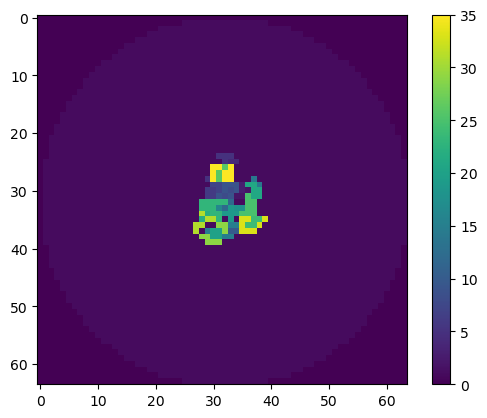

Final cell cores


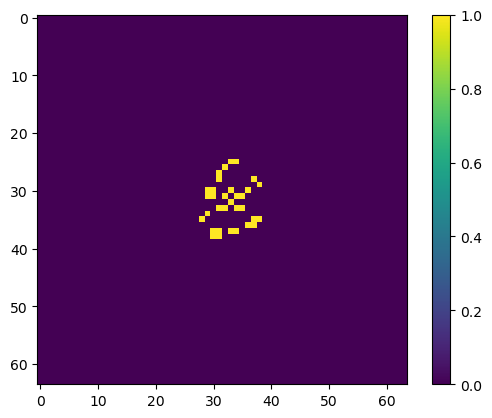

In [13]:
# Run first day and look at the results
run_day(dish)
extract_cell_data(dish)

# Count cells
indices = numpy.unique(dish)
cell_ids = list()
for index in indices:
    if index != 0 and index % 2 == 0:
        cell_ids.append(index // 2)

print(f"Final dish cells")
matplotlib.pyplot.imshow(dish)
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

print(f"Final cell cores")
matplotlib.pyplot.imshow(numpy.logical_and(dish % 2 == 0, dish != 0))
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [ ]:
data_folder = pathlib.Path("./data")

zoom_factors = [1, 2, 2, 3, 3, 3, 3, 3, 4, 4, 5]

dish_radius = 1024
# Run for all dishes
for dish_index in range(1, 6):
    dish = create_dish(dish_radius)
    seed_dish(dish)
    # Run the other 12 days
    for day in range(1, 13):
        zoom = random.choice(zoom_factors)
        file_name = f"Day_{day}_dish_{dish_index}_zoom_{zoom}.csv"
        run_day(dish)
        file_str = extract_cell_data(dish)
        csv_file_path = data_folder / file_name
        with csv_file_path.open("w") as csv_file:
            first_line = True
            for line in file_str:
                if not first_line:
                    cell_id, nucleus_x, nucleus_y, nucleus_area, body_area, body_x, body_y = line.split(",")
                    nucleus_x = int(nucleus_x) * zoom + random.randint(-zoom, zoom + 1)
                    nucleus_y = int(nucleus_y) * zoom + random.randint(-zoom, zoom + 1)
                    nucleus_area = int(nucleus_area) * zoom + random.randint(-zoom, zoom + 1)
                    body_x = int(body_x) * zoom + random.randint(-zoom, zoom + 1)
                    body_y = int(body_y) * zoom + random.randint(-zoom, zoom + 1)
                    body_area = int(body_area) * zoom + random.randint(-zoom, zoom + 1)
                    csv_file.write(f"{cell_id}, {nucleus_x}, {nucleus_y}, {nucleus_area}, {body_area}, {body_x}, {body_y}\n")
                else:
                    csv_file.write(line + "\n")
                    first_line = False
        print(f"{csv_file_path} written")
    break

data\Day_1_dish_1_zoom_1.csv written
